In [ ]:
pip install termcolor pyfiglet

In [53]:
pip install prophet


# Import Libraries



In [22]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from scipy.stats import yeojohnson
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')


# Load Data

In [23]:


# Function to load daily data
def load_daily_data():
    engine = create_engine('mssql+pyodbc:///?odbc_connect=DRIVER={SQL Server};SERVER=LAPTOP-PTEGCH09\\SQLSERVER122;DATABASE=DW_SAP_Co2;Trusted_Connection=yes;')
    df = pd.read_sql(""" 
        SELECT f.Carbon_Foot_Print_per_Unit_kgCo2, d.FullDate 
        FROM Fact_Co2_Emissions f 
        JOIN Dim_Date d ON f.Fk_Date = d.Pk_Date 
        ORDER BY d.FullDate
    """, engine)
    df['Date'] = pd.to_datetime(df['FullDate'])
    return df.set_index('Date')['Carbon_Foot_Print_per_Unit_kgCo2']

# Stationarity Test

Why it's important:
Many statistical models (like ARIMA) assume stationarity, so checking and ensuring it helps in building accurate models.

* ACF (Autocorrelation Function):
ACF measures the correlation between a time series and its own past values (lags). It helps identify:

Repeating patterns (seasonality)

Whether a time series is stationary
* PACF (Partial Autocorrelation Function):
PACF measures the direct effect of a lag on the series, excluding the effects of earlier lags. It helps:

Identify how many lags directly influence the series²

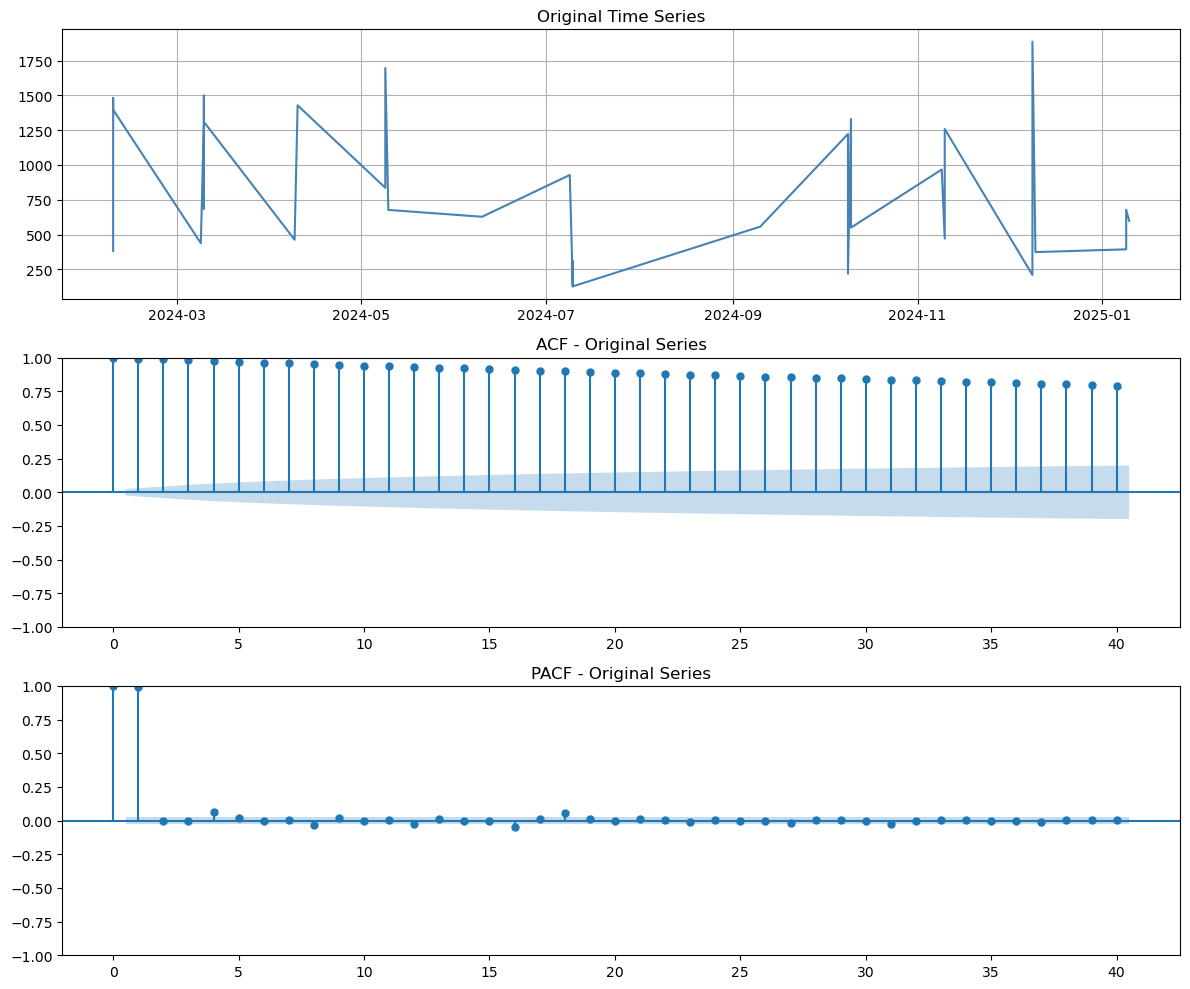

In [24]:

# Load and transform data
ts = load_daily_data()

fig, axes = plt.subplots(3, 1, figsize=(12, 10))
axes[0].plot(ts, color='steelblue')
axes[0].set_title('Original Time Series')
axes[0].grid()
plot_acf(ts, lags=40, ax=axes[1])
axes[1].set_title('ACF - Original Series')
plot_pacf(ts, lags=40, ax=axes[2])
axes[2].set_title('PACF - Original Series')
plt.tight_layout()
plt.show()


# Inverse Yeo-Johnson

*This transforms your non-normal time series (ts) into a more normal-like distribution.

*Unlike Box-Cox, Yeo-Johnson supports both positive and negative values.

*lambda_ is the parameter found automatically to best normalize the data.

In [25]:

# Function to apply inverse Yeo-Johnson transformation
def inverse_yeojohnson(y, lmbda):
    y = np.asarray(y)
    if lmbda == 0:
        return np.exp(y) - 1
    elif lmbda == 2:
        return np.expm1(y)
    elif lmbda != 0:
        pos = y >= 0
        neg = ~pos
        out = np.empty_like(y)
        out[pos] = np.power(y[pos] * lmbda + 1, 1 / lmbda) - 1
        out[neg] = -np.power(-(2 - lmbda) * y[neg] + 1, 1 / (2 - lmbda)) + 1
        return out
    else:
        raise ValueError("Invalid lambda value")


# Yeo_Johnson Transformation

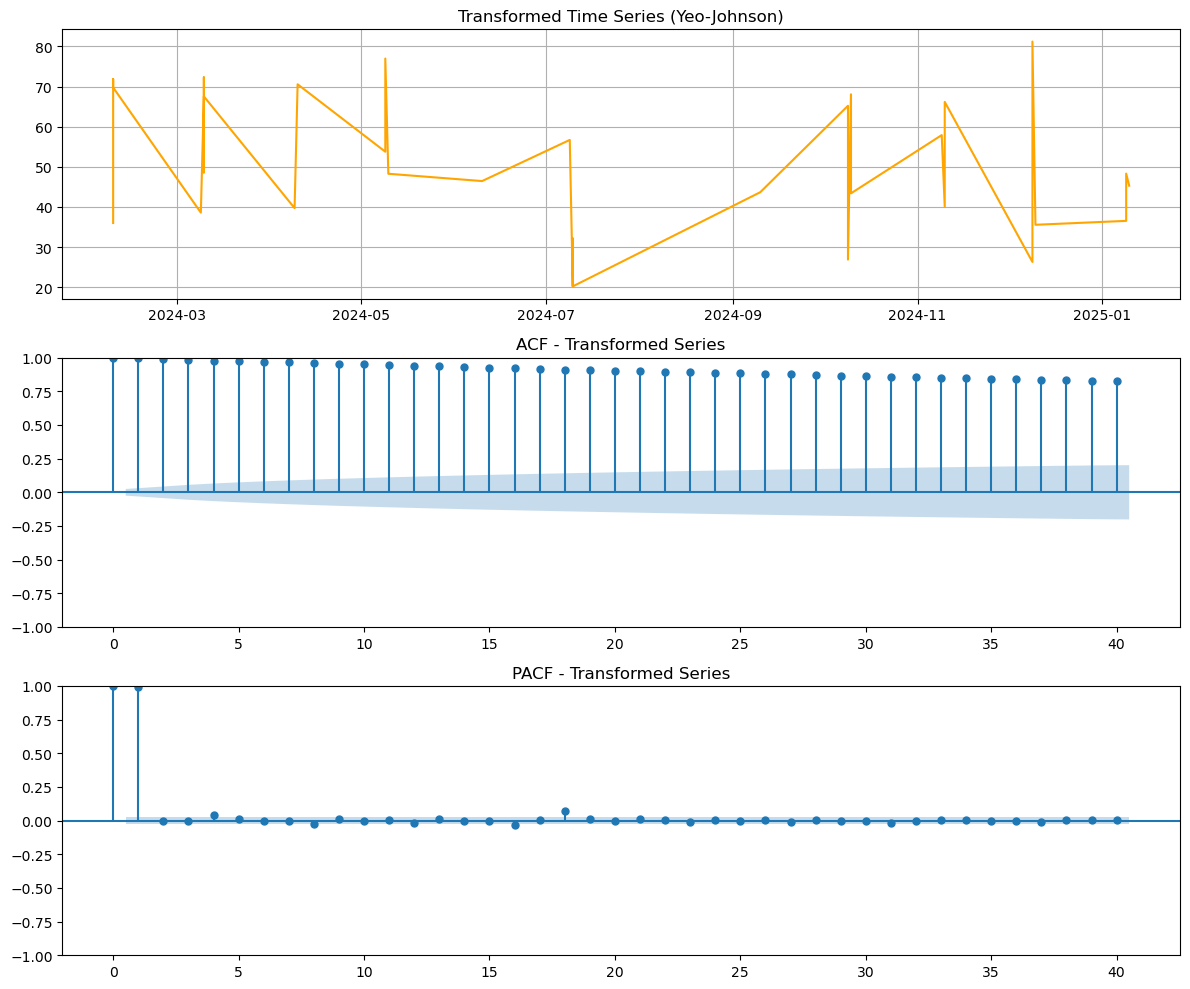

Lambda value: 0.4922945764662902


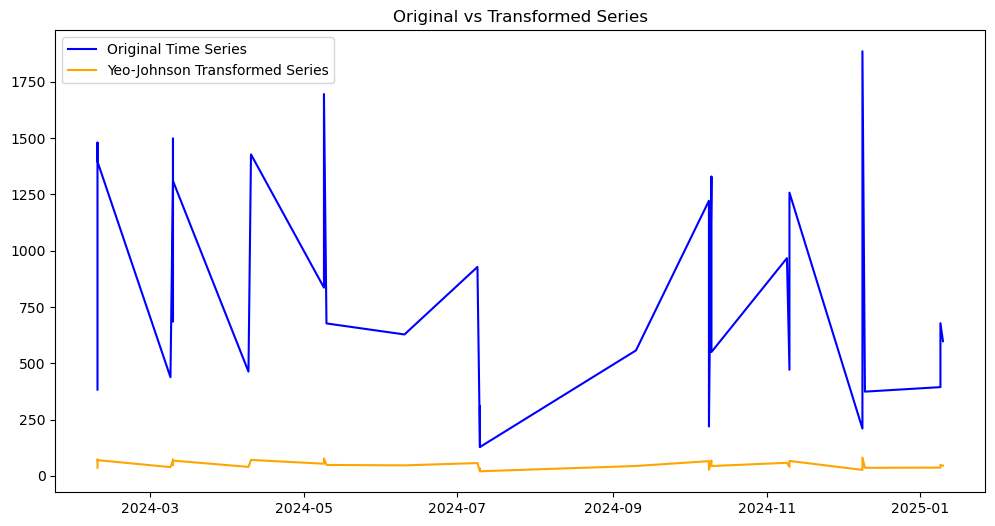

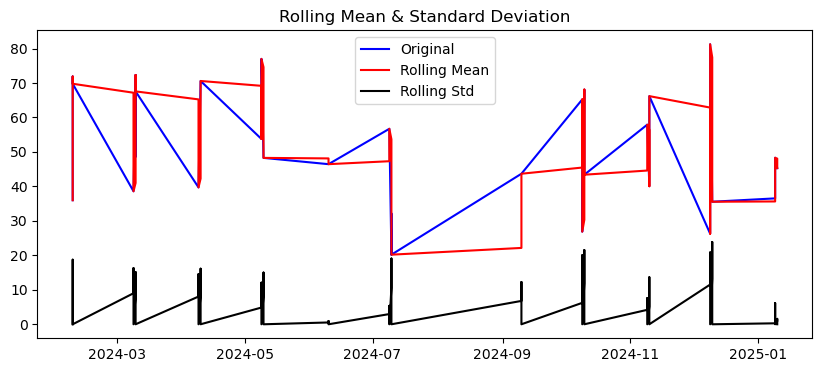

Results of Dickey-Fuller Test:
Test Statistic                   -3.724627
p-value                           0.003780
#Lags Used                       17.000000
Number of Observations Used    6153.000000
Critical Value (1%)              -3.431413
Critical Value (5%)              -2.862010
Critical Value (10%)             -2.567020
dtype: float64


In [26]:
# Yeo-Johnson transformation
# tore transformed values in a Series
ts_transformed, lambda_ = yeojohnson(ts)
ts_normalized_series = pd.Series(ts_transformed, index=ts.index)
# Plot Transformed Series, ACF, and PACF
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
axes[0].plot(ts_normalized_series, color='orange')
axes[0].set_title('Transformed Time Series (Yeo-Johnson)')
axes[0].grid()
plot_acf(ts_normalized_series, lags=40, ax=axes[1])
axes[1].set_title('ACF - Transformed Series')
plot_pacf(ts_normalized_series, lags=40, ax=axes[2])
axes[2].set_title('PACF - Transformed Series')
plt.tight_layout()
plt.show()

#This value was chosen automatically by the Yeo-Johnson transformation to best stabilize the variance and normalize your data 
print(f"Lambda value: {lambda_}")
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Original Time Series', color='blue')
plt.plot(ts_normalized_series, label='Yeo-Johnson Transformed Series', color='orange')
plt.title('Original vs Transformed Series')
plt.legend()
plt.show()

test_stationarity(ts_normalized_series)

# Models 

# ETS ( Exponential smoothing state space model)

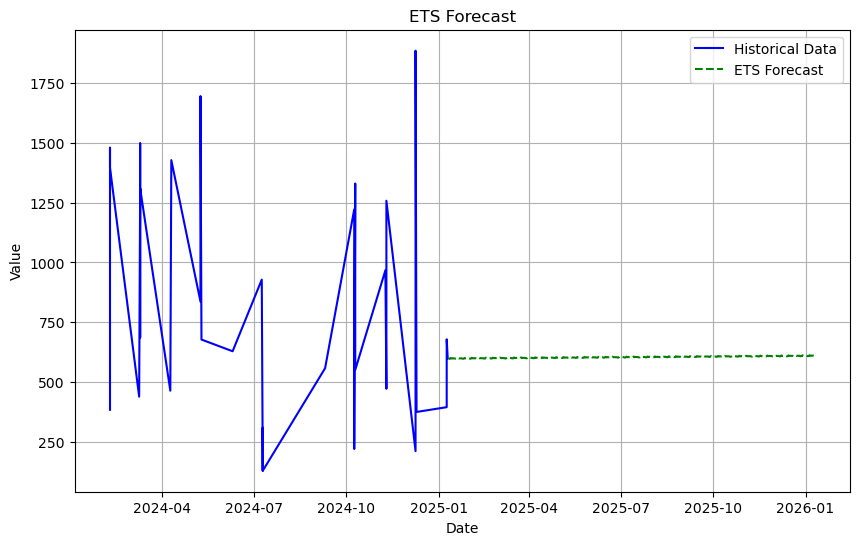

In [27]:
# Fit the ETS model
ets_model = ExponentialSmoothing(ts_transformed, trend='add', seasonal='add', seasonal_periods=7).fit()

# Forecast for the next 365 days
forecast_ets = ets_model.forecast(steps=365)

# Convert the forecast into a time series (reversing transformations if necessary)
forecast_ets_original_series = pd.Series(
    inverse_yeojohnson(forecast_ets, lambda_),
    index=pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=365, freq='D')
)

# Plot the historical series and ETS forecasts
plt.figure(figsize=(10,6))
plt.plot(ts, label='Historical Data', color='blue')
plt.plot(forecast_ets_original_series, label='ETS Forecast', color='green', linestyle='--')
plt.title('ETS Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


# SARIMA

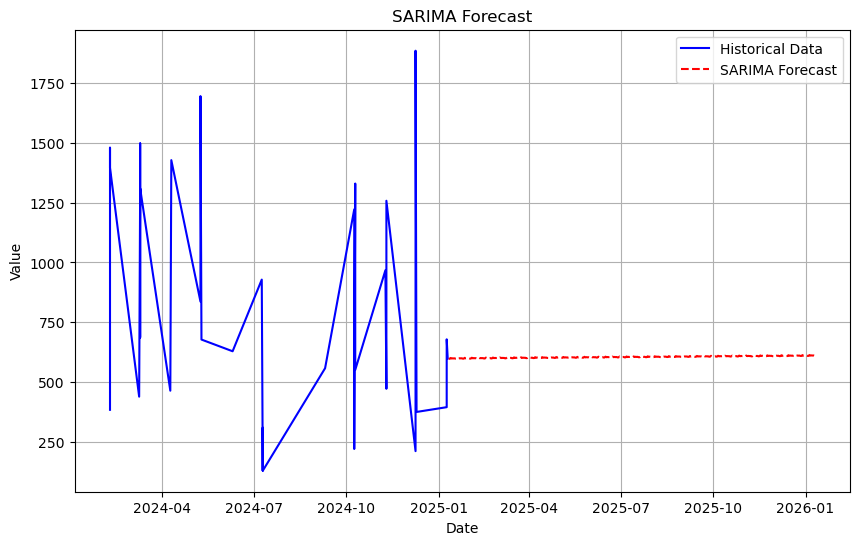

In [30]:


# Fit the SARIMA model
sarima_model = SARIMAX(
    ts_transformed,
    order=(1, 1, 2),  # (p, d, q) parameters for ARIMA
    seasonal_order=(1, 1, 1, 7),  # (P, D, Q, S) seasonal parameters
).fit()

# Forecast for the next 365 days
forecast_sarima = sarima_model.forecast(steps=365)

# Convert the forecast into a time series (reversing transformations if necessary)
forecast_sarima_original_series = pd.Series(
    inverse_yeojohnson(forecast_sarima, lambda_),
    index=pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=365, freq='D')
)

# Plot the historical series and SARIMA forecasts
plt.figure(figsize=(10, 6))
plt.plot(ts, label='Historical Data', color='blue')
plt.plot(forecast_sarima_original_series, label='SARIMA Forecast', color='red', linestyle='--')
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


# Comparing between SARIMA & ETS

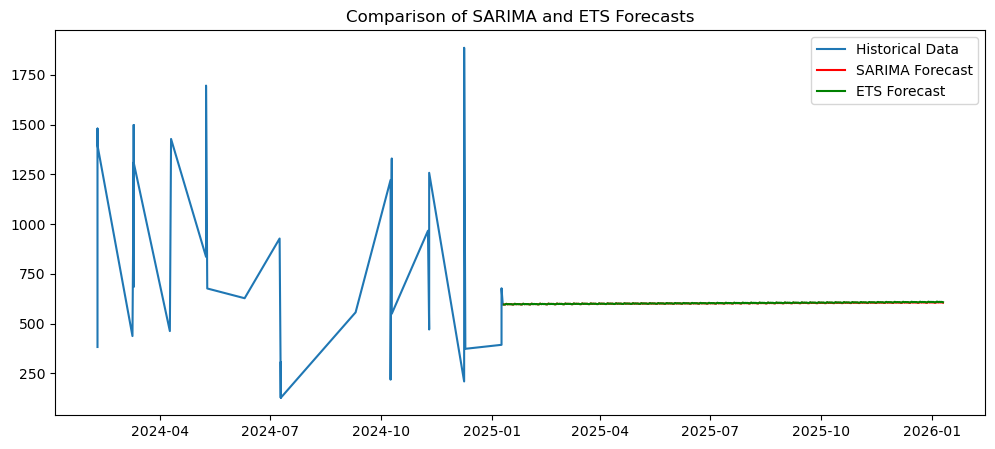

In [29]:
# Compare SARIMA and ETS
plt.figure(figsize=(12, 5))
plt.plot(ts, label='Historical Data')
plt.plot(forecast_sarima_original_series.index, forecast_sarima_original_series, label="SARIMA Forecast", color='red')
plt.plot(forecast_ets_original_series.index, forecast_ets_original_series, label="ETS Forecast", color='green')
plt.title('Comparison of SARIMA and ETS Forecasts')
plt.legend()
plt.show()

After reviewing the visual comparison, both the ETS and SARIMA models provide very similar forecasts, 
capturing the underlying patterns and seasonality effectively. To quantify the differences, we will use RMSE, MAE, and MAPE.
These metrics will help evaluate the models’ accuracy and provide a clear comparison of their forecasting performance.

* MAPE shows the percentage error.

* RMSE emphasizes larger errors more.

* MAE provides a simple average of errors, with all errors treated equally.

In [78]:
# 4. Error Comparison (RMSE, MAE, and MAPE)

actual = ts[-365:]  # The last 365 days as the actual test data

# Compare the forecasts for the next 365 days
rmse_sarima = np.sqrt(mean_squared_error(actual, forecast_sarima_original_series))
rmse_ets = np.sqrt(mean_squared_error(actual, forecast_ets_original_series))

mae_sarima = mean_absolute_error(actual, forecast_sarima_original_series)
mae_ets = mean_absolute_error(actual, forecast_ets_original_series)

# MAPE Calculation for SARIMA
mape_sarima = np.mean(np.abs((actual.values - forecast_sarima_original_series.values) / actual.values)) * 100

# MAPE Calculation for ETS
mape_ets = np.mean(np.abs((actual.values - forecast_ets_original_series.values) / actual.values)) * 100

# Display RMSE, MAE, and MAPE results
print(f"RMSE SARIMA: {rmse_sarima:.4f}")
print(f"RMSE ETS: {rmse_ets:.4f}")
print(f"MAE SARIMA: {mae_sarima:.4f}")
print(f"MAE ETS: {mae_ets:.4f}")
print(f"MAPE SARIMA: {mape_sarima:.2f}%")
print(f"MAPE ETS: {mape_ets:.2f}%")

# Performance comparison based on RMSE, MAE, and MAPE
if rmse_sarima < rmse_ets and mae_sarima < mae_ets and mape_sarima < mape_ets:
    print("✅ SARIMA model is more performant.")
else:
    print("✅ ETS model is more performant.")

# 5. Analyze the residuals (errors)
residuals_sarima = actual - forecast_sarima_original_series
residuals_ets = actual - forecast_ets_original_series


RMSE SARIMA: 5.2966
RMSE ETS: 6.5740
MAE SARIMA: 4.5775
MAE ETS: 5.6119
MAPE SARIMA: 0.77%
MAPE ETS: 0.94%
✅ SARIMA model is more performant.


Conclusion: The SARIMA model performs better, with lower values for MSE, RMSE, MAE, and MAPE, indicating a more accurate forecast.

# HoltWinters

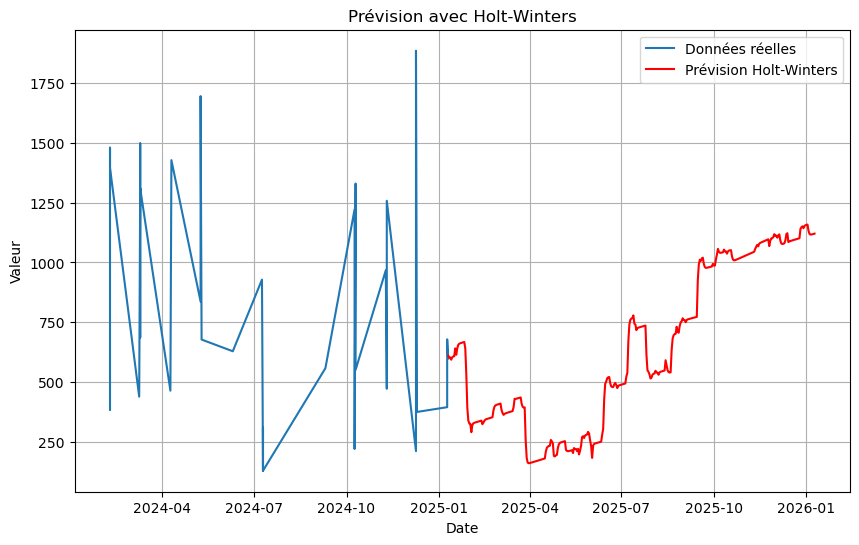

RMSE du modèle Holt-Winters : 166.4489


In [66]:
model = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=365)
holt_winters_fit = model.fit()

# Prédiction
forecast_holt_winters = holt_winters_fit.forecast(steps=365)  # Prédiction pour 365 jours

# Visualiser les résultats
plt.figure(figsize=(10, 6))
plt.plot(ts, label='Données réelles')
plt.plot(pd.date_range(start=ts.index[-1], periods=365, freq='D'), forecast_holt_winters, label='Prévision Holt-Winters', color='red')
plt.title('Prévision avec Holt-Winters')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True)
plt.show()

# Calculer l'erreur RMSE (si vous avez des données de test réelles)
actual = ts[-30:]  # Par exemple, en utilisant les 30 derniers jours comme données réelles pour la comparaison
rmse_holt_winters = np.sqrt(mean_squared_error(actual, forecast_holt_winters[:30]))  # Comparer les 30 premiers jours
print(f"RMSE du modèle Holt-Winters : {rmse_holt_winters:.4f}")

# Comparing between SARIMA & Holt-WINTERS

In [70]:

# Assume ts is loaded from your data
ts = load_daily_data()  # Example of loading data

# 1. Holt-Winters Model
model_hw = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=365)
holt_winters_fit = model_hw.fit()

# Holt-Winters Forecast for 365 days
forecast_hw = holt_winters_fit.forecast(steps=365)

# 2. SARIMA Model
sarima_model = SARIMAX(ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_results = sarima_model.fit()
forecast_sarima = sarima_results.get_forecast(steps=365)
forecast_sarima_mean = forecast_sarima.predicted_mean

# Compare with the last 30 days of actual data
actual = ts[-30:]


# RMSE

In [72]:

# RMSE for Holt-Winters
rmse_hw = np.sqrt(mean_squared_error(actual, forecast_hw[:30]))

# RMSE for SARIMA
rmse_sarima = np.sqrt(mean_squared_error(actual, forecast_sarima_mean[:30]))


print(f"RMSE SARIMA: {rmse_sarima:.4f}")
print(f"RMSE Holt-Winters: {rmse_hw:.4f}")
# Display which model is better
if rmse_sarima < rmse_hw:
    print("✅ SARIMA model performs better.")
else:
    print("✅ Holt-Winters model performs better.")

RMSE SARIMA: 1.4436
RMSE Holt-Winters: 166.4489
✅ SARIMA model performs better.


# MAE

In [74]:
# MAE for Holt-Winters
mae_hw = mean_absolute_error(actual, forecast_hw[:30])

# MAE for SARIMA
mae_sarima = mean_absolute_error(actual, forecast_sarima_mean[:30])

# Display MAE results
print(f"MAE SARIMA: {mae_sarima:.4f}")
print(f"MAE Holt-Winters: {mae_hw:.4f}")

# Compare and print which model is better based on MAE
if mae_sarima < mae_hw:
    print("✅ SARIMA is the better model based on MAE.")
else:
    print("✅ Holt-Winters is the better model based on MAE.")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Actual Data')

# Ensure that the forecast data is indexed correctly, using the same start date
forecast_sarima_index = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=365, freq='D')
forecast_hw_index = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=365, freq='D')

plt.plot(forecast_sarima_index, forecast_sarima_mean, label='SARIMA Forecast', color='red')
plt.plot(forecast_hw_index, forecast_hw, label='Holt-Winters Forecast', color='green')

plt.legend()
plt.title('SARIMA vs Holt-Winters Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()


MAE SARIMA: 1.2162
MAE Holt-Winters: 121.4864


# MAPE

MAPE SARIMA: 0.20%
MAPE Holt-Winters: 20.32%
✅ SARIMA is the better model based on MAPE.


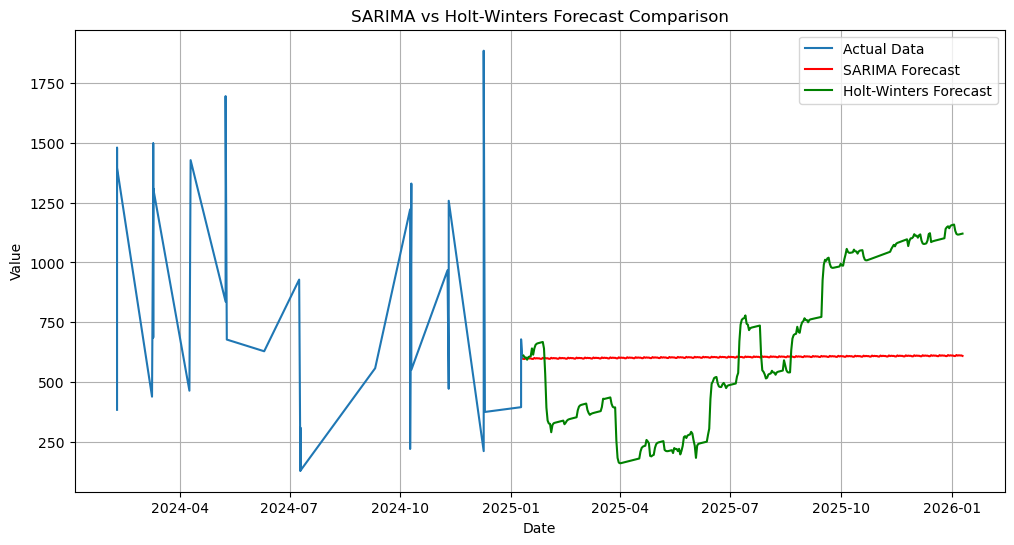

In [77]:
# MAPE for Holt-Winters
mape_hw = np.mean(np.abs((actual.values - forecast_hw[:30]) / actual.values)) * 100

# MAPE for SARIMA
mape_sarima = np.mean(np.abs((actual.values - forecast_sarima_mean[:30]) / actual.values)) * 100

# Display MAPE results
print(f"MAPE SARIMA: {mape_sarima:.2f}%")
print(f"MAPE Holt-Winters: {mape_hw:.2f}%")

# Compare and print which model is better
if mape_sarima < mape_hw:
    print("✅ SARIMA is the better model based on MAPE.")
else:
    print("✅ Holt-Winters is the better model based on MAPE.")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Actual Data')

# Ensure that the forecast data is indexed correctly, using the same start date
forecast_sarima_index = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=365, freq='D')
forecast_hw_index = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=365, freq='D')

plt.plot(forecast_sarima_index, forecast_sarima_mean, label='SARIMA Forecast', color='red')
plt.plot(forecast_hw_index, forecast_hw, label='Holt-Winters Forecast', color='green')

plt.legend()
plt.title('SARIMA vs Holt-Winters Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()


# Conclusion

After applying the SARIMA model to the non-stationary time series, it outperformed the ETS model in terms of MSE, RMSE, MAE, and MAPE
indicating that SARIMA is better suited for capturing the underlying patterns. 
The time series was transformed to ensure stationarity, which improved the model's forecasting accuracy.

WHY SARIMA ?

* Handling Non-Stationarity
* Capturing Seasonality
* Performance Metrics